<a href="https://colab.research.google.com/github/karabomaboka/21DaysLockdown-DS-Projects/blob/master/Pre_Umoja_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',50)
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


In [ ]:
train=pd.read_csv("/content/drive/My Drive/PIE_FINANCILAL_INCLUSION/Train.csv")
test=pd.read_csv('/content/drive/My Drive/PIE_FINANCILAL_INCLUSION/Test.csv')

In [ ]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 23524 rows and 13 columns.
Test dataset has 10086 rows and 12 columns.


In [ ]:
train.head(3)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed


In [ ]:
train["bank_account"] = pd.get_dummies(train['bank_account'], columns = ['bank_account'], prefix = ['bank_account'], drop_first = True)

In [ ]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
def missing(df):
    missing_df = pd.DataFrame({'features': df.columns})
    missing_df['missing%'] = missing_df['features'].map(df.isnull()[missing_df['features']].sum() * 100 / df.shape[0])
    missing_df = missing_df.sort_values(by = 'missing%', ascending = False)
    return missing_df

In [ ]:
train_missing=missing(train)
test_missing=missing(test)

In [ ]:
train_missing

,features,missing%
0,country,0.0
1,year,0.0
2,uniqueid,0.0
3,bank_account,0.0
4,location_type,0.0
5,cellphone_access,0.0
6,household_size,0.0
7,age_of_respondent,0.0
8,gender_of_respondent,0.0
9,relationship_with_head,0.0


In [ ]:
test_missing

,features,missing%
0,country,0.0
1,year,0.0
2,uniqueid,0.0
3,location_type,0.0
4,cellphone_access,0.0
5,household_size,0.0
6,age_of_respondent,0.0
7,gender_of_respondent,0.0
8,relationship_with_head,0.0
9,marital_status,0.0


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
year,23524.0,2016.975939,0.847371,2016.0,2016.0,2017.0,2018.0,2018.0
bank_account,23524.0,0.140792,0.347815,0.0,0.0,0.0,0.0,1.0
household_size,23524.0,3.681602,2.279956,0.0,2.0,3.0,5.0,21.0
age_of_respondent,23524.0,38.805220,16.520569,16.0,26.0,35.0,49.0,100.0


In [ ]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
year,10086.0,2016.975907,0.847356,2016.0,2016.0,2017.0,2018.0,2018.0
household_size,10086.0,3.661511,2.265658,0.0,2.0,3.0,5.0,20.0
age_of_respondent,10086.0,38.308348,16.270053,16.0,26.0,35.0,48.0,100.0


# Unique_features

In [ ]:
feat_counts=train.nunique(dropna=False)
feat_counts.sort_values()[:10]

bank_account               2
location_type              2
cellphone_access           2
gender_of_respondent       2
year                       3
country                    4
marital_status             5
relationship_with_head     6
education_level            7
job_type                  10
dtype: int64

# Constant_features

In [ ]:
constant_features = feat_counts.loc[feat_counts==1].index.tolist()
print (constant_features)

[]


# have a look at categorical and numerical columns

In [ ]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns)

In [ ]:
print(num_cols)
print(cat_cols)

['year', 'bank_account', 'household_size', 'age_of_respondent']
['country', 'uniqueid', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


# Analysis by pivoting features

1.country

In [ ]:
train[['country', 'bank_account']].groupby(['country'], as_index=False).mean().sort_values(by='bank_account', ascending=False)

,country,bank_account
0,Kenya,0.250659
1,Rwanda,0.114825
2,Tanzania,0.091692
3,Uganda,0.086149


2.location_type

In [ ]:
train[['location_type', 'bank_account']].groupby(['location_type'], as_index=False).mean().sort_values(by='bank_account', ascending=False)

,location_type,bank_account
1,Urban,0.178739
0,Rural,0.116503


3.education_level

In [ ]:
train[['education_level', 'bank_account']].groupby(['education_level'], as_index=False).mean().sort_values(by='bank_account', ascending=False)

,education_level,bank_account
2,Other/Dont know/RTA,0.750000
6,Vocational/Specialised training,0.570361
5,Tertiary education,0.510804
4,Secondary education,0.232773
0,6,0.185185
3,Primary education,0.085451
1,No formal education,0.038981


# Concat the two datasets

In [ ]:
split=train.shape[0]
datasets=pd.concat([train,test],axis=0)

# Numerica Data

In [ ]:
#1.age
print("Maximum Age",datasets['age_of_respondent'].max())
print("Minimun Age",datasets['age_of_respondent'].min())

Maximum Age 100
Minimun Age 16


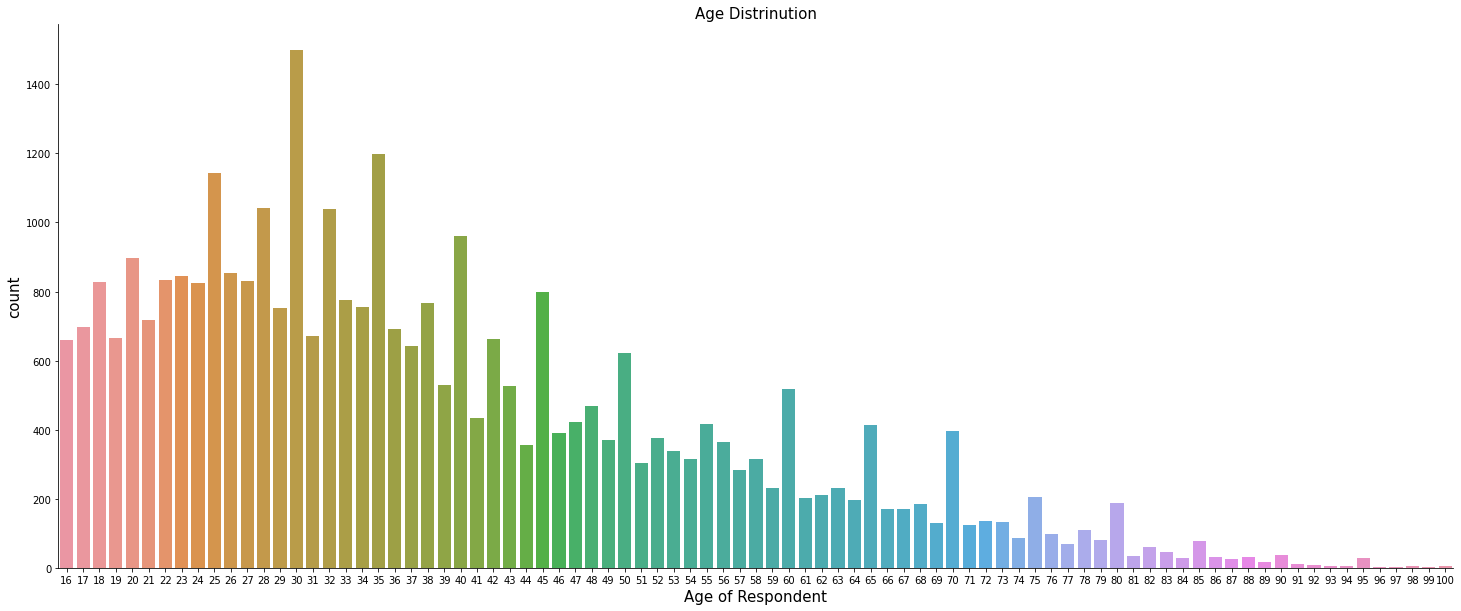

In [ ]:
#Visualizing Age
fig,ax=plt.subplots()
fig.set_size_inches(25,10)
sns.countplot(x='age_of_respondent',data=datasets)
ax.set_xlabel('Age of Respondent',fontsize=15)
ax.set_ylabel('count',fontsize=15)
ax.set_title("Age Distrinution",fontsize=15)
sns.despine()

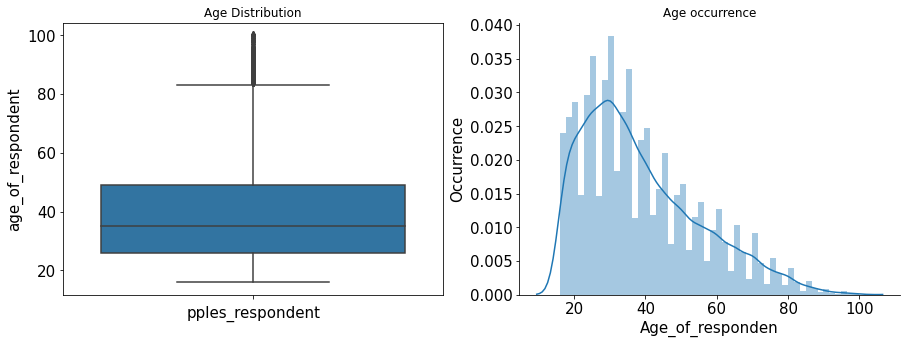

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.boxplot(x='age_of_respondent',data=datasets,orient='v',ax=ax1)
ax1.set_xlabel('pple''s_respondent',fontsize=15)
ax1.set_ylabel('age_of_respondent',fontsize=15)
ax1.set_title('Age Distribution')
ax1.tick_params(labelsize=15)

sns.distplot(datasets['age_of_respondent'],ax=ax2)
ax2.set_xlabel('Age_of_responden',fontsize=15)
ax2.set_ylabel('Occurrence',fontsize=15)
ax2.set_title("Age occurrence")
sns.despine(ax=ax2)
ax2.tick_params(labelsize=15)


In [ ]:
#Calculating quartiles
print('1st quartile',datasets['age_of_respondent'].quantile(q=0.25))
print('2nd quartile',datasets['age_of_respondent'].quantile(q=0.5))
print('3rd quartile',datasets['age_of_respondent'].quantile(q=0.75))
print('4th quartile',datasets['age_of_respondent'].quantile(q=1))

1st quartile 26.0
2nd quartile 35.0
3rd quartile 49.0
4th quartile 100.0


In [ ]:
#checking for possibility of outliers in age
'''
InterquartileRange,IQR=Q3-Q1
lower 1.5*IQR whisker=Q1-1.5*IQR
upper 1.5*IQR whisker=Q3+1.5*IQR
'''
print('Ages Above',datasets['age_of_respondent'].quantile(q=0.75)+1.5*(datasets['age_of_respondent'].quantile(q=0.75)-datasets['age_of_respondent'].quantile(q=0.25)),'seems to be outliers')

Ages Above 83.5 seems to be outliers


In [ ]:
#print number of outliers
print('number of respondents above 83.5 are:',datasets[datasets['age_of_respondent']>83.5]['age_of_respondent'].count())
print('% above 83.5:',datasets[datasets['age_of_respondent']>83.5]['age_of_respondent'].count()/len(datasets)*100,'%')

number of respondents above 83.5 are: 327
% above 83.5: 0.9729247247842904 %


# 2.Household size

In [ ]:

print("Maximum household size",datasets['household_size'].max())
print("Minimun household size",datasets['household_size'].min())

Maximum household size 21
Minimun household size 0


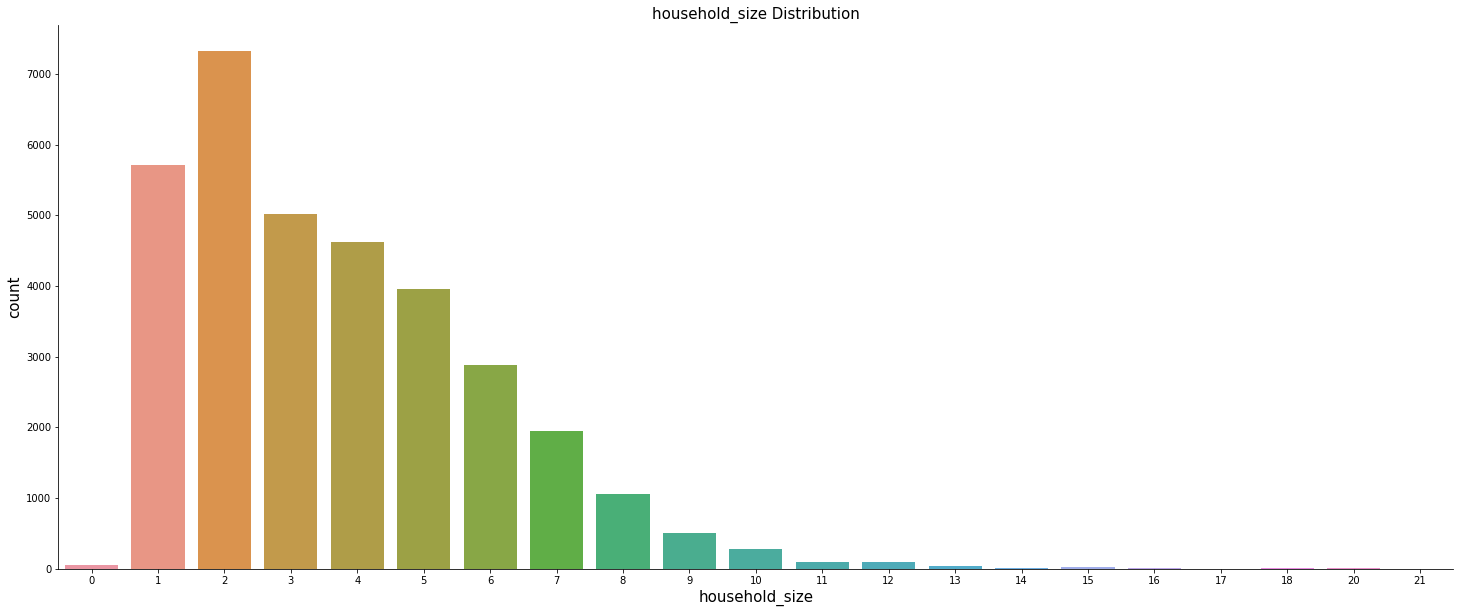

In [ ]:
#Visualizing Age
fig,ax=plt.subplots()
fig.set_size_inches(25,10)
sns.countplot(x='household_size',data=datasets)
ax.set_xlabel('household_size',fontsize=15)
ax.set_ylabel('count',fontsize=15)
ax.set_title("household_size Distribution",fontsize=15)
sns.despine()

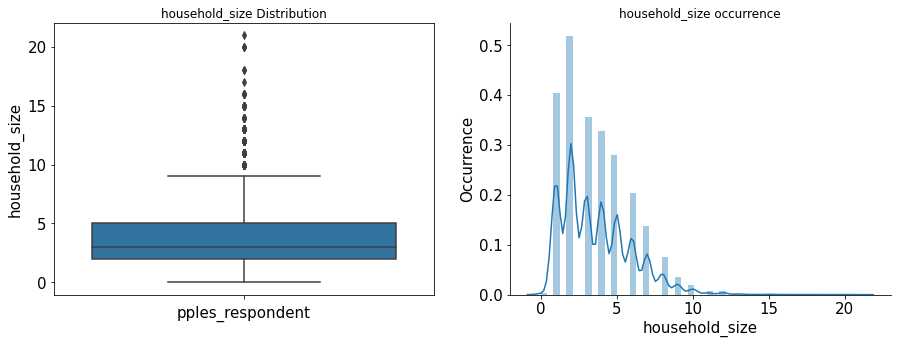

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.boxplot(x='household_size',data=datasets,orient='v',ax=ax1)
ax1.set_xlabel('pple''s_respondent',fontsize=15)
ax1.set_ylabel('household_size',fontsize=15)
ax1.set_title('household_size Distribution')
ax1.tick_params(labelsize=15)

sns.distplot(datasets['household_size'],ax=ax2)
ax2.set_xlabel('household_size',fontsize=15)
ax2.set_ylabel('Occurrence',fontsize=15)
ax2.set_title("household_size occurrence")
sns.despine(ax=ax2)
ax2.tick_params(labelsize=15)


# Categorical Variables

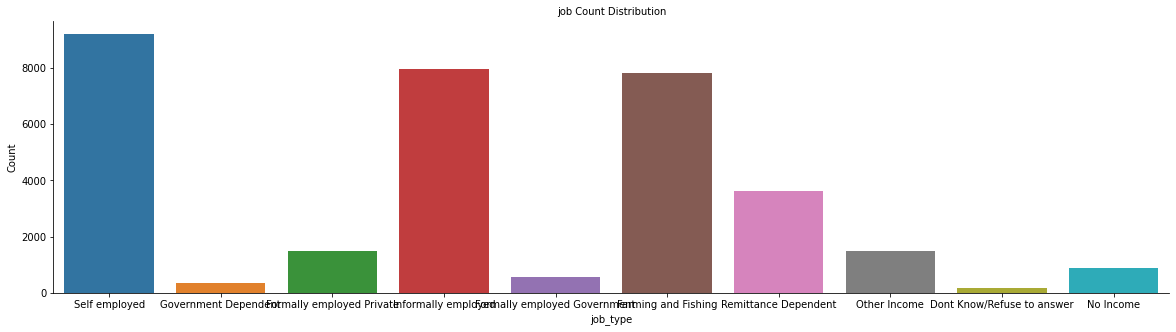

In [ ]:
#1.job type
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(x = 'job_type', data = datasets)
ax.set_xlabel('job_type', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('job Count Distribution', fontsize=10)
ax.tick_params(labelsize=10)
sns.despine()

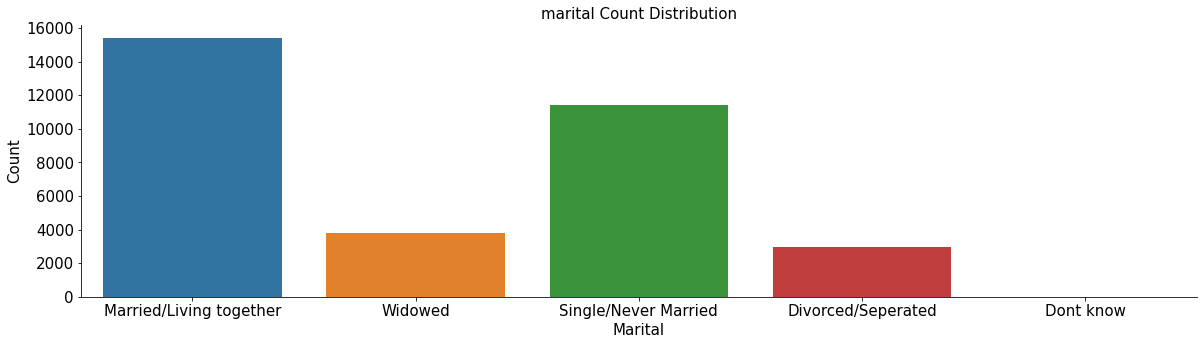

In [ ]:
#2.Marital status
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(x = 'marital_status', data = datasets)
ax.set_xlabel('Marital', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('marital Count Distribution', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

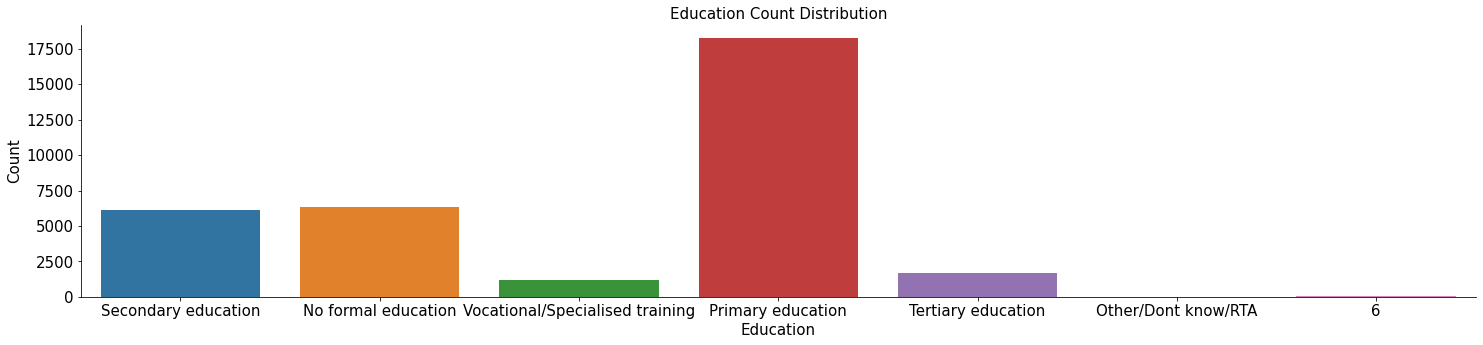

In [ ]:
#3.Education
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
sns.countplot(x = 'education_level', data = datasets)
ax.set_xlabel('Education', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Education Count Distribution', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

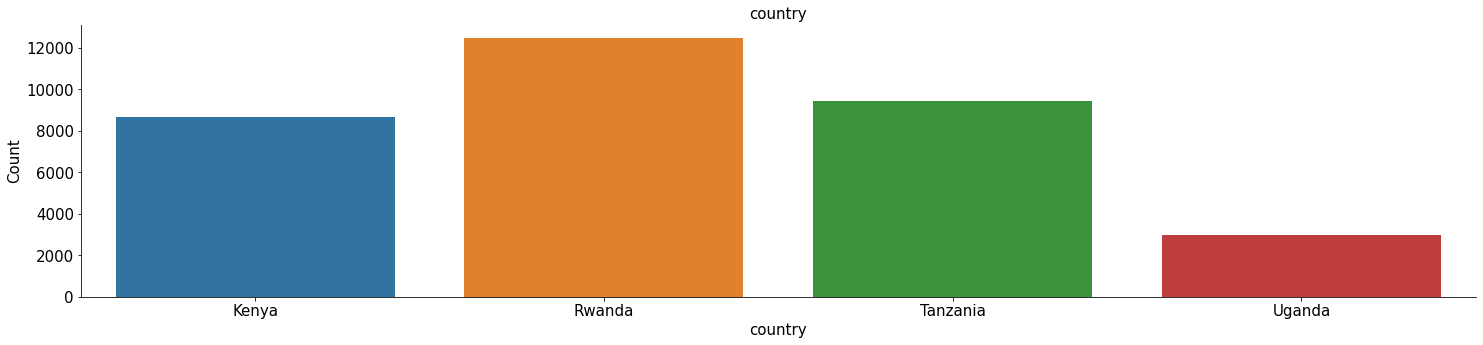

In [ ]:
#.country
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
sns.countplot(x = 'country', data = datasets)
ax.set_xlabel('country', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('country', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

# LOcation

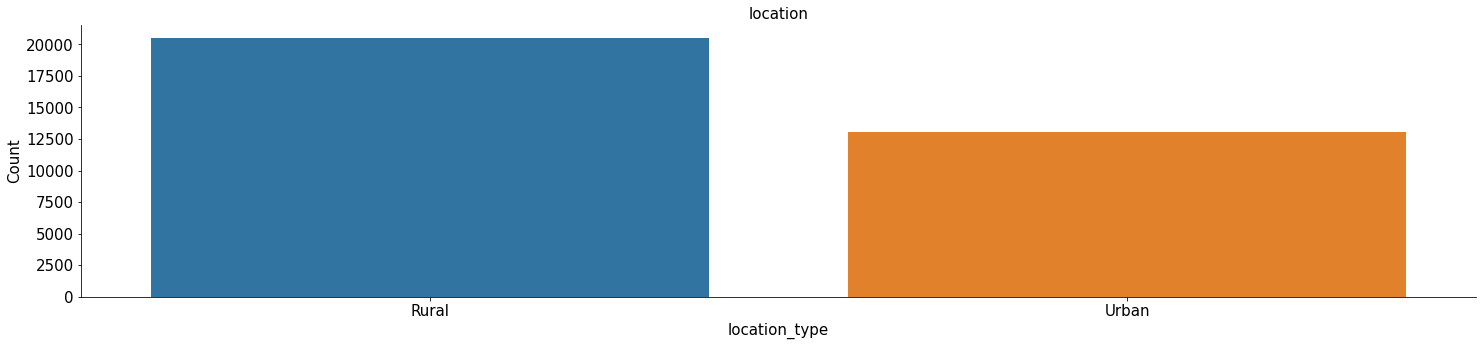

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
sns.countplot(x = 'location_type', data = datasets)
ax.set_xlabel('location_type', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('location', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

# 6.Cellophone access

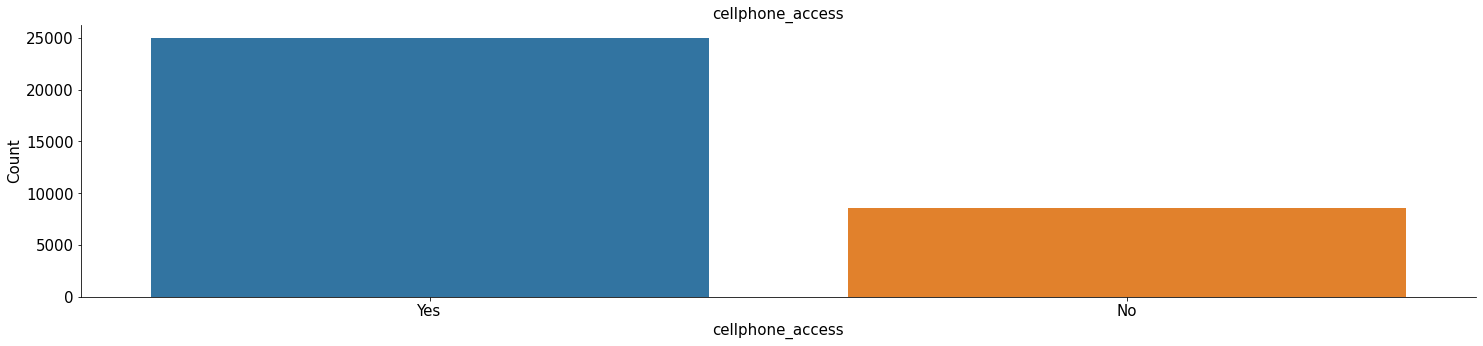

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 5)
sns.countplot(x = 'cellphone_access', data = datasets)
ax.set_xlabel('cellphone_access', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('cellphone_access', fontsize=15)
ax.tick_params(labelsize=15)
sns.despine()

# Feature Engineering

In [ ]:
i_cols=['age_of_respondent','household_size','year']

In [ ]:
for col in i_cols:
    fq_encode = datasets[col].value_counts().to_dict()   
    datasets[col+'_fq_enc'] = datasets[col].map(fq_encode)

In [ ]:
datasets.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_of_respondent_fq_enc,household_size_fq_enc,year_fq_enc
0,Kenya,2018,uniqueid_1,1.0,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,826,5015,11671
1,Kenya,2018,uniqueid_2,0.0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,396,3963,11671
2,Kenya,2018,uniqueid_3,1.0,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,854,3963,11671
3,Kenya,2018,uniqueid_4,0.0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,754,3963,11671
4,Kenya,2018,uniqueid_5,0.0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,854,1055,11671


In [ ]:
#interactions

datasets["age_div_hs"]=datasets.age_of_respondent/datasets.household_size
datasets["age_sub_hs"]=datasets.age_of_respondent-datasets.household_size
datasets["log10_age"]=datasets.age_of_respondent/10
datasets["log100_age"]=datasets.age_of_respondent/100
datasets["agevsdiv_hs"]=datasets.age_of_respondent-datasets.age_div_hs
datasets["agevssub_hs"]=datasets.age_of_respondent-datasets.age_sub_hs
datasets["log10vslog100"]=datasets.log10_age-datasets.log100_age
datasets["Agelog"]=datasets.agevsdiv_hs-datasets.log10vslog100

datasets["log10_household"]=datasets.log10_age-datasets.household_size
datasets["agelog10"]=datasets.age_of_respondent-datasets.log10_age

datasets["year_log10"]=datasets.year/10
datasets["year_log100"]=datasets.year/100
datasets["year_age"]=datasets.year-datasets.age_of_respondent
datasets["yearage2"]=datasets.year/datasets.age_of_respondent
datasets["yearhousehold"]=datasets.year/datasets.household_size


In [ ]:
datasets.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_of_respondent_fq_enc,household_size_fq_enc,year_fq_enc,age_div_hs,age_sub_hs,log10_age,log100_age,agevsdiv_hs,agevssub_hs,log10vslog100,Agelog,log10_household,agelog10,year_log10,year_log100,year_age,yearage2,yearhousehold
0,Kenya,2018,uniqueid_1,1.0,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,826,5015,11671,8.00,21,2.4,0.24,16.00,3,2.16,13.84,-0.6,21.6,201.8,20.18,1994,84.083333,672.666667
1,Kenya,2018,uniqueid_2,0.0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,396,3963,11671,14.00,65,7.0,0.70,56.00,5,6.30,49.70,2.0,63.0,201.8,20.18,1948,28.828571,403.600000
2,Kenya,2018,uniqueid_3,1.0,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,854,3963,11671,5.20,21,2.6,0.26,20.80,5,2.34,18.46,-2.4,23.4,201.8,20.18,1992,77.615385,403.600000
3,Kenya,2018,uniqueid_4,0.0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,754,3963,11671,6.80,29,3.4,0.34,27.20,5,3.06,24.14,-1.6,30.6,201.8,20.18,1984,59.352941,403.600000
4,Kenya,2018,uniqueid_5,0.0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,854,1055,11671,3.25,18,2.6,0.26,22.75,8,2.34,20.41,-5.4,23.4,201.8,20.18,1992,77.615385,252.250000


In [ ]:

datasets1=pd.get_dummies(datasets['country'], drop_first=True)
datasets2=pd.get_dummies(datasets['year'], drop_first=True)
datasets3=pd.get_dummies(datasets['location_type'], drop_first=True)
datasets4=pd.get_dummies(datasets['cellphone_access'], drop_first=True)
datasets5=pd.get_dummies(datasets['gender_of_respondent'], drop_first=True)
datasets6=pd.get_dummies(datasets['relationship_with_head'], drop_first=True)
datasets7=pd.get_dummies(datasets['marital_status'], drop_first=True)
datasets8=pd.get_dummies(datasets['education_level'], drop_first=True)
datasets9=pd.get_dummies(datasets['job_type'], drop_first=True)




datasets=datasets.drop(['country'], axis=1)
datasets=datasets.drop(['year'], axis=1)
datasets=datasets.drop(['location_type'], axis=1)
datasets=datasets.drop(['cellphone_access'], axis=1)
datasets=datasets.drop(['gender_of_respondent'], axis=1)
datasets=datasets.drop(['relationship_with_head'], axis=1)
datasets=datasets.drop(['marital_status'], axis=1)
datasets=datasets.drop(['education_level'], axis=1)
datasets=datasets.drop(['job_type'], axis=1)


In [ ]:
datasets=pd.concat([datasets,datasets1,datasets2,datasets3,datasets4,datasets5,datasets6,datasets7,datasets8,datasets9], axis=1)


In [ ]:
datasets.head()

,uniqueid,bank_account,household_size,age_of_respondent,age_of_respondent_fq_enc,household_size_fq_enc,year_fq_enc,age_div_hs,age_sub_hs,log10_age,log100_age,agevsdiv_hs,agevssub_hs,log10vslog100,Agelog,log10_household,agelog10,year_log10,year_log100,year_age,yearage2,yearhousehold,Rwanda,Tanzania,Uganda,...,Male,Head of Household,Other non-relatives,Other relative,Parent,Spouse,Dont know,Married/Living together,Single/Never Married,Widowed,No formal education,Other/Dont know/RTA,Primary education,Secondary education,Tertiary education,Vocational/Specialised training,Farming and Fishing,Formally employed Government,Formally employed Private,Government Dependent,Informally employed,No Income,Other Income,Remittance Dependent,Self employed
0,uniqueid_1,1.0,3,24,826,5015,11671,8.00,21,2.4,0.24,16.00,3,2.16,13.84,-0.6,21.6,201.8,20.18,1994,84.083333,672.666667,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,uniqueid_2,0.0,5,70,396,3963,11671,14.00,65,7.0,0.70,56.00,5,6.30,49.70,2.0,63.0,201.8,20.18,1948,28.828571,403.600000,0,0,0,...,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,uniqueid_3,1.0,5,26,854,3963,11671,5.20,21,2.6,0.26,20.80,5,2.34,18.46,-2.4,23.4,201.8,20.18,1992,77.615385,403.600000,0,0,0,...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,uniqueid_4,0.0,5,34,754,3963,11671,6.80,29,3.4,0.34,27.20,5,3.06,24.14,-1.6,30.6,201.8,20.18,1984,59.352941,403.600000,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,uniqueid_5,0.0,8,26,854,1055,11671,3.25,18,2.6,0.26,22.75,8,2.34,20.41,-5.4,23.4,201.8,20.18,1992,77.615385,252.250000,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#datasets.drop(['uniqueid'],inplace=True,axis=1)

# separate our data back

In [ ]:
train=datasets[:split]
test=datasets[split:]

In [ ]:
train.head()

,uniqueid,bank_account,household_size,age_of_respondent,age_of_respondent_fq_enc,household_size_fq_enc,year_fq_enc,age_div_hs,age_sub_hs,log10_age,log100_age,agevsdiv_hs,agevssub_hs,log10vslog100,Agelog,log10_household,agelog10,year_log10,year_log100,year_age,yearage2,yearhousehold,Rwanda,Tanzania,Uganda,...,Male,Head of Household,Other non-relatives,Other relative,Parent,Spouse,Dont know,Married/Living together,Single/Never Married,Widowed,No formal education,Other/Dont know/RTA,Primary education,Secondary education,Tertiary education,Vocational/Specialised training,Farming and Fishing,Formally employed Government,Formally employed Private,Government Dependent,Informally employed,No Income,Other Income,Remittance Dependent,Self employed
0,uniqueid_1,1.0,3,24,826,5015,11671,8.00,21,2.4,0.24,16.00,3,2.16,13.84,-0.6,21.6,201.8,20.18,1994,84.083333,672.666667,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,uniqueid_2,0.0,5,70,396,3963,11671,14.00,65,7.0,0.70,56.00,5,6.30,49.70,2.0,63.0,201.8,20.18,1948,28.828571,403.600000,0,0,0,...,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,uniqueid_3,1.0,5,26,854,3963,11671,5.20,21,2.6,0.26,20.80,5,2.34,18.46,-2.4,23.4,201.8,20.18,1992,77.615385,403.600000,0,0,0,...,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,uniqueid_4,0.0,5,34,754,3963,11671,6.80,29,3.4,0.34,27.20,5,3.06,24.14,-1.6,30.6,201.8,20.18,1984,59.352941,403.600000,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,uniqueid_5,0.0,8,26,854,1055,11671,3.25,18,2.6,0.26,22.75,8,2.34,20.41,-5.4,23.4,201.8,20.18,1992,77.615385,252.250000,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
n_folds=5
num_boost_round=300
kf = StratifiedKFold(n_splits = n_folds, random_state = 15, shuffle = True)
oof_lgb= np.zeros(train.shape[0])
predictions_lgb= np.zeros(test.shape[0])
cols = [c for c in train.columns if c not in ['bank_account','uniqueid']]

params = {'objective' : 'binary',
          'boosting_type' : 'gbdt',
          'num_threads': 4,
          'learning_rate': 0.02,
          'max_depth' : 10,
          'tree_learner' : 'serial',
          'feature_fraction': 0.65,
          'bagging_freq' : 5,
          'bagging_fraction':0.85,
          'verbosity': 1,
          "metric":"binary_error"
          }
for train_index, val_index in kf.split(train, train.bank_account):
    X_train, X_val = train[cols].iloc[train_index], train[cols].iloc[val_index]
    y_train, y_val = train.bank_account[train_index], train.bank_account[val_index]
    
    dtrain=lgbm.Dataset(data=X_train,label=y_train)
    dval=lgbm.Dataset(data=X_val,label=y_val)
    model = lgbm.train(params=params,train_set=dtrain,num_boost_round=num_boost_round,
                        valid_sets=(dtrain, dval),early_stopping_rounds=50,verbose_eval=50)
    
    best_iteration = model.best_iteration
   
    oof_lgb[val_index]= model.predict(X_val,num_iteration=best_iteration)>0.5
    predictions_lgb= ((model.predict(test[cols],num_iteration=best_iteration)) >0.5)/n_folds
    
print(1-accuracy_score(oof_lgb,train.bank_account))

Training until validation scores don't improve for 50 rounds.
[50]	training's binary_error: 0.120623	valid_1's binary_error: 0.120935
[100]	training's binary_error: 0.108295	valid_1's binary_error: 0.112646
[150]	training's binary_error: 0.104681	valid_1's binary_error: 0.110308
Early stopping, best iteration is:
[146]	training's binary_error: 0.104416	valid_1's binary_error: 0.110308
Training until validation scores don't improve for 50 rounds.
[50]	training's binary_error: 0.119773	valid_1's binary_error: 0.126036
[100]	training's binary_error: 0.108826	valid_1's binary_error: 0.110521
[150]	training's binary_error: 0.106276	valid_1's binary_error: 0.109883
[200]	training's binary_error: 0.104256	valid_1's binary_error: 0.107758
[250]	training's binary_error: 0.102715	valid_1's binary_error: 0.106482
[300]	training's binary_error: 0.101281	valid_1's binary_error: 0.10627
Did not meet early stopping. Best iteration is:
[297]	training's binary_error: 0.101281	valid_1's binary_error: 0.

In [ ]:
test=pd.read_csv('/content/drive/My Drive/PIE_FINANCILAL_INCLUSION/Test.csv')

In [ ]:
sub_df=pd.read_csv("/content/drive/My Drive/PIE_FINANCILAL_INCLUSION/SubmissionFile.csv")

In [ ]:
sub_df.head()

,uniqueid,bank_account
0,uniqueid_7867 x Kenya,1.0
1,uniqueid_6722 x Kenya,0.0
2,uniqueid_6714 x Kenya,1.0
3,uniqueid_8103 x Kenya,1.0
4,uniqueid_8657 x Kenya,1.0


In [ ]:
sub_df['uniqueid']=test["uniqueid"]+" x "+test["country"]
sub_df['bank_account'] = (predictions_lgb)>0
sub_df[["bank_account"]]=sub_df[["bank_account"]].astype(int)

sub_df.to_csv('submission_lgb.csv', index = False)

In [ ]:
sub_df.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)


In [ ]:
create_download_link(filename='submission_lgb.csv')

In [ ]:
from google.colab import files
files.download('submission_lgb.csv') 